# Unsupervised machine learning for object differentiation
In this notebook we attempt to differentiate 8-shaped objects from round objects using unsupervised machine learning. Eventually we will get an idea which features allow us to differentiate these objects.

In [1]:
from skimage.io import imread
from skimage.measure import label
from napari_skimage_regionprops import regionprops_table
import stackview
import pandas as pd
import numpy as np
from umap import UMAP
import seaborn
import pyclesperanto_prototype as cle
from skimage.data import human_mitosis

We load and visualize the example data first.

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
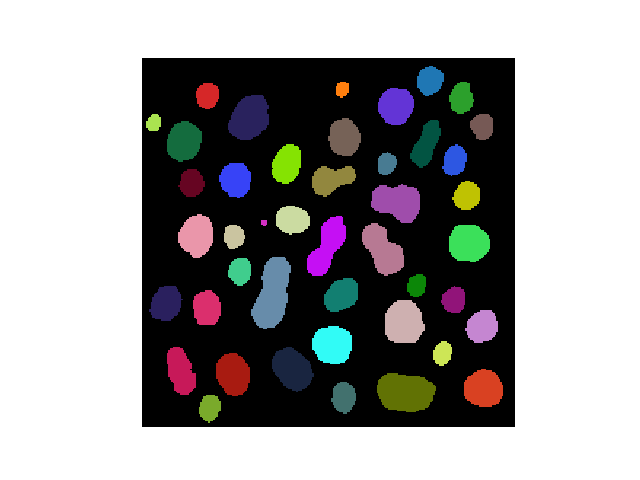

In [2]:
image = imread("data/blobs.tif")
labels = label(image > 120)
labels = cle.exclude_small_labels(labels, maximum_size=4)
labels = cle.exclude_labels_on_edges(labels)
stackview.insight(labels)

As we want to differentiate objects using quantitative measurements, we extract those like this.

In [3]:
measurements = regionprops_table(image, labels, intensity=True, size=True, shape=True)
measurements.head(5)

,label,area,bbox_area,equivalent_diameter,convex_area,max_intensity,mean_intensity,min_intensity,extent,local_centroid-0,...,solidity,feret_diameter_max,major_axis_length,minor_axis_length,orientation,eccentricity,standard_deviation_intensity,aspect_ratio,roundness,circularity
0,1,285.0,378.0,19.049233,295.0,248.0,204.294737,128.0,0.753968,9.757895,...,0.966102,21.840330,20.506730,17.770536,-0.344111,0.499054,36.500576,1.153974,0.862903,0.958941
1,2,81.0,99.0,10.155413,86.0,200.0,161.481481,128.0,0.818182,4.777778,...,0.941860,12.083046,11.153514,9.239435,-0.369542,0.560155,19.357017,1.207164,0.829033,1.038068
2,3,278.0,374.0,18.813840,297.0,224.0,174.848921,128.0,0.743316,10.794964,...,0.936027,23.086793,22.298284,16.037201,-0.084591,0.694790,25.426411,1.390410,0.711889,0.883826
3,4,231.0,288.0,17.149879,243.0,240.0,188.467532,128.0,0.802083,8.090909,...,0.950617,19.313208,18.345742,16.073821,-0.174639,0.482019,30.533319,1.141343,0.873879,0.972748
4,5,501.0,650.0,25.256544,518.0,232.0,189.141717,128.0,0.770769,12.191617,...,0.967181,27.513633,26.232105,24.403675,-0.316746,0.366805,25.456900,1.074924,0.927004,0.945559


In [4]:
measurements.describe().T

,count,mean,std,min,25%,50%,75%,max
label,44.0,22.500000,12.845233,1.000000,11.750000,22.500000,33.250000,44.000000
area,44.0,401.863636,202.852288,14.000000,242.750000,406.500000,547.500000,902.000000
bbox_area,44.0,542.750000,295.106376,16.000000,318.250000,528.500000,702.000000,1350.000000
equivalent_diameter,44.0,21.781085,6.174086,4.222008,17.580464,22.749685,26.402420,33.888967
convex_area,44.0,423.295455,216.613747,14.000000,254.750000,427.500000,565.750000,981.000000
max_intensity,44.0,234.909091,17.517856,152.000000,232.000000,240.000000,248.000000,248.000000
mean_intensity,44.0,190.116971,15.034153,138.857143,182.815316,190.688843,199.153996,219.915171
min_intensity,44.0,128.000000,0.000000,128.000000,128.000000,128.000000,128.000000,128.000000
extent,44.0,0.758804,0.063276,0.551039,0.751693,0.770000,0.787927,0.875000
local_centroid-0,44.0,11.439824,4.126230,1.285714,8.642122,10.946602,13.254249,25.144124


## Cleaning data
In the following we replace `inf` and `nan` values with zeros. This is partially dangerous, because will will make average measurements misleading. It is however necessary so that we can apply the UMAP algorithm to the data.

In [5]:
measurements = measurements.replace([np.inf, -np.inf, np.nan], 0)

In [6]:
print("DataFrame contains NaNs:", measurements.isna().any().any())

DataFrame contains NaNs: False


These are all columns in the data:

In [7]:
measurements.columns

Index(['label', 'area', 'bbox_area', 'equivalent_diameter', 'convex_area',
       'max_intensity', 'mean_intensity', 'min_intensity', 'extent',
       'local_centroid-0', 'local_centroid-1', 'solidity',
       'feret_diameter_max', 'major_axis_length', 'minor_axis_length',
       'orientation', 'eccentricity', 'standard_deviation_intensity',
       'aspect_ratio', 'roundness', 'circularity'],
      dtype='object')

In [8]:
measurements.describe().T

,count,mean,std,min,25%,50%,75%,max
label,44.0,22.500000,12.845233,1.000000,11.750000,22.500000,33.250000,44.000000
area,44.0,401.863636,202.852288,14.000000,242.750000,406.500000,547.500000,902.000000
bbox_area,44.0,542.750000,295.106376,16.000000,318.250000,528.500000,702.000000,1350.000000
equivalent_diameter,44.0,21.781085,6.174086,4.222008,17.580464,22.749685,26.402420,33.888967
convex_area,44.0,423.295455,216.613747,14.000000,254.750000,427.500000,565.750000,981.000000
max_intensity,44.0,234.909091,17.517856,152.000000,232.000000,240.000000,248.000000,248.000000
mean_intensity,44.0,190.116971,15.034153,138.857143,182.815316,190.688843,199.153996,219.915171
min_intensity,44.0,128.000000,0.000000,128.000000,128.000000,128.000000,128.000000,128.000000
extent,44.0,0.758804,0.063276,0.551039,0.751693,0.770000,0.787927,0.875000
local_centroid-0,44.0,11.439824,4.126230,1.285714,8.642122,10.946602,13.254249,25.144124


## Column selection and dimensionality reduction
We next select columns that are reasonable to differentiate objects and compute a UMAP from them.

In [9]:
selected_measurements = measurements[[
        'area', 
        'equivalent_diameter', 
        'convex_area',
        'max_intensity', 
        'mean_intensity', 
        'min_intensity', 
        'extent',
        'solidity',
        'feret_diameter_max', 
        'major_axis_length', 
        'minor_axis_length',
        'eccentricity', 
        'standard_deviation_intensity',
        'aspect_ratio', 
        'roundness', 
        'circularity']]
selected_measurements.describe().T

,count,mean,std,min,25%,50%,75%,max
area,44.0,401.863636,202.852288,14.000000,242.750000,406.500000,547.500000,902.000000
equivalent_diameter,44.0,21.781085,6.174086,4.222008,17.580464,22.749685,26.402420,33.888967
convex_area,44.0,423.295455,216.613747,14.000000,254.750000,427.500000,565.750000,981.000000
max_intensity,44.0,234.909091,17.517856,152.000000,232.000000,240.000000,248.000000,248.000000
mean_intensity,44.0,190.116971,15.034153,138.857143,182.815316,190.688843,199.153996,219.915171
min_intensity,44.0,128.000000,0.000000,128.000000,128.000000,128.000000,128.000000,128.000000
extent,44.0,0.758804,0.063276,0.551039,0.751693,0.770000,0.787927,0.875000
solidity,44.0,0.953153,0.024749,0.866477,0.948846,0.961628,0.966970,1.000000
feret_diameter_max,44.0,26.382434,8.915046,4.472136,20.167557,26.112023,31.231386,52.201533
major_axis_length,44.0,25.876797,9.591558,4.208834,19.176806,25.307650,30.317106,54.785426


In [10]:
# configure UMAP algorithm
umap = UMAP(n_neighbors=5, n_components=2)

# apply algorithm
transformed_data = umap.fit_transform(selected_measurements.values.tolist())

# store results back in table
measurements['UMAP0'] = transformed_data[:,0]
measurements['UMAP1'] = transformed_data[:,1]

C:\Users\rober\miniforge3\envs\bio11\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


This is how the UMAP looks like:

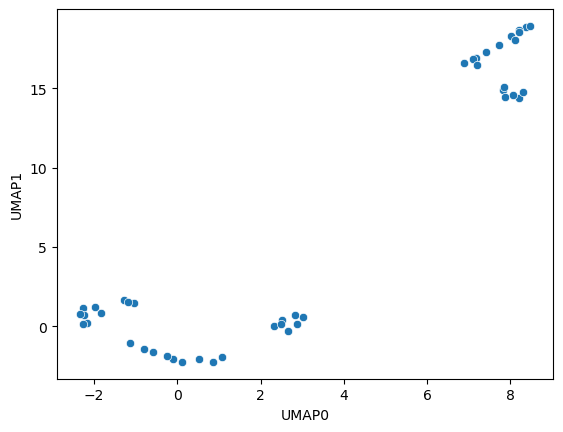

In [11]:
seaborn.scatterplot(measurements, x='UMAP0', y='UMAP1');

## REQUIRED INTERACTION
In the stackview.clusterplot tool we can use a lasso-annotation to identify the cluster that corresponds to the 8-shaped objects. Continue executing Jupyter notebook cells once you have a visualization that is similar to the screen shown below.

In [13]:
stackview.clusterplot(measurements, labels, column_x='UMAP0', column_y='UMAP1')

We next retrieve the annotation like this:

In [18]:
print(measurements['selection'].to_list())

[False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, True, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False]


## Correlation statistics
We can then visualize a cross-correlation matrix of all parameters with each other, including our annotation. This facilitates to identify columns that allow differentiation of objects from others.

In [19]:
def colorize(styler):
    styler.background_gradient(axis=None, cmap="PiYG")
    return styler

df = measurements.corr().T
df.style.pipe(colorize)

,label,area,bbox_area,equivalent_diameter,convex_area,max_intensity,mean_intensity,min_intensity,extent,local_centroid-0,local_centroid-1,solidity,feret_diameter_max,major_axis_length,minor_axis_length,orientation,eccentricity,standard_deviation_intensity,aspect_ratio,roundness,circularity,UMAP0,UMAP1,selection
label,1.000000,0.261682,0.223070,0.249249,0.250594,0.110791,0.235692,nan,0.031673,0.177363,0.227746,0.090163,0.208067,0.198908,0.237521,0.319053,0.059804,0.189165,0.036433,-0.055815,-0.054152,-0.146322,-0.215255,0.080739
area,0.261682,1.000000,0.973718,0.978723,0.997560,0.511730,0.530250,nan,-0.362472,0.847281,0.935689,-0.243908,0.930981,0.911069,0.859240,0.280673,0.348585,0.288670,0.411794,-0.415592,-0.626241,-0.601202,-0.843525,0.677335
bbox_area,0.223070,0.973718,1.000000,0.948328,0.985584,0.481524,0.476951,nan,-0.546728,0.902854,0.904551,-0.416707,0.973189,0.967337,0.752580,0.213080,0.479196,0.267528,0.581132,-0.569335,-0.718764,-0.564720,-0.804863,0.719434
equivalent_diameter,0.249249,0.978723,0.948328,1.000000,0.974614,0.633984,0.618553,nan,-0.395696,0.858779,0.947036,-0.266587,0.931696,0.904412,0.904698,0.197456,0.363799,0.402328,0.386884,-0.406856,-0.701230,-0.652534,-0.864780,0.590973
convex_area,0.250594,0.997560,0.985584,0.974614,1.000000,0.506730,0.517356,nan,-0.413323,0.862417,0.934090,-0.305706,0.948048,0.932682,0.832264,0.263176,0.389269,0.285105,0.462720,-0.464090,-0.659125,-0.591018,-0.833974,0.700457
max_intensity,0.110791,0.511730,0.481524,0.633984,0.506730,1.000000,0.825115,nan,-0.324093,0.504879,0.603305,-0.253635,0.536089,0.502524,0.645600,-0.139025,0.246172,0.867057,0.121313,-0.191680,-0.636372,-0.343749,-0.412949,0.156570
mean_intensity,0.235692,0.530250,0.476951,0.618553,0.517356,0.825115,1.000000,nan,-0.160940,0.412859,0.609264,-0.077797,0.458515,0.422638,0.707711,0.132754,0.017030,0.902001,-0.044872,0.009002,-0.411166,-0.421974,-0.508856,0.074372
min_intensity,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
extent,0.031673,-0.362472,-0.546728,-0.395696,-0.413323,-0.324093,-0.160940,nan,1.000000,-0.631158,-0.375580,0.853431,-0.631776,-0.664733,-0.062873,0.252915,-0.756019,-0.216260,-0.848271,0.834550,0.808533,0.188903,0.265716,-0.371454
local_centroid-0,0.177363,0.847281,0.902854,0.858779,0.862417,0.504879,0.412859,nan,-0.631158,1.000000,0.706437,-0.439244,0.937673,0.932889,0.623186,0.003490,0.560853,0.284331,0.678234,-0.638667,-0.785693,-0.522464,-0.713830,0.582543


## Exercise
The UMAP-generation above is done without parameters such as centroid and orientation. Why?

## Exercise
Repeat the procedure above with the dataset human_mitosis. Identify parameters for differentiating the small bright cells from the others. ([hint](https://focalplane.biologists.com/2022/05/23/explorative-image-data-science-with-napari/))

In [ ]:
image = human_mitosis()
stackview.insight(image)